#  Use case-3 : Predict Customer Sentiment

# Problem statement --

# In the current world, there is no automatic system in place to find whether customer's feedback is positive or negative or neutral. 
# Build a classification model to decide whether it is a positive or negative or neutral category.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from datetime import datetime
import os
import re
from bs4 import BeautifulSoup

#  1. Type of ML problem

 ====== It is a multi class classification problem.
 
 Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class.
 
 __Credit__: http://scikit-learn.org/stable/modules/multiclass.html

In this problem, each of the sample can take only 1 label - positive OR negative OR neutral

# 2. Performance metric

we will use F1 score. we will try to build a model with higher F1 score.

# 3. Exploratory data analysis
# Assumption - we are doing analysis across airlines. We are not focussing on any specific airline.

==== 3.1 Data loading ====

In [2]:
originalData = pd.read_csv('Usecase3_Dataset.csv')

In [3]:
originalData.head(5)

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


Converting CSV data into .db as its easy to query data.

==== 3.2 Check for missing values ====

In [4]:
originalData.info()
# we could see that there are no null values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


# ==== 3.3 Check for duplicate data ====

it is necessary to check for duplicates in order to get unbiased results for the analysis of the data.

Converting CSV data into .db as its easy to query data.

In [5]:
conn = sqlite3.connect('data.db')

In [6]:
originalData.to_sql('data', conn, if_exists='replace', index=False)

In [7]:
startTime = datetime.now()
dupRecords = pd.read_sql_query(""" SELECT airline_sentiment,airline,text,COUNT(*) AS cnt_duplicates FROM data GROUP BY
airline_sentiment,airline,text """, conn)
print("total time taken to find duplicate records ", datetime.now()-startTime)

total time taken to find duplicate records  0:00:00.077419


In [8]:
conn.close()

In [9]:
dupRecords.head(5)

,airline_sentiment,airline,text,cnt_duplicates
0,negative,American,#nothelpful MT @AmericanAir: Our call volume i...,1
1,negative,American,.@AmericanAir (2/3) ...I sat on the runway for...,1
2,negative,American,.@AmericanAir @C2Next Would be great to get so...,1
3,negative,American,.@AmericanAir @Kaha58 Would be nice if you cou...,1
4,negative,American,.@AmericanAir @USAirways Add insult to injury ...,1


In [10]:
# number of times each record appeared in our database
dupRecords['cnt_duplicates'].value_counts()

1    14286
2      154
3        6
5        4
4        2
Name: cnt_duplicates, dtype: int64

In [11]:
# find no of duplicate records.
dupRecords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14452 entries, 0 to 14451
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14452 non-null  object
 1   airline            14452 non-null  object
 2   text               14452 non-null  object
 3   cnt_duplicates     14452 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 451.8+ KB


In [15]:
# total no of OR % of duplicate records.
print(" total no of duplicate records ", 14640 - 14452)
print(" % of duplicate records ", round((14640 - 14452)/14640*100,2))

 total no of duplicate records  188
 % of duplicate records  1.28


# we need to remove duplicate records.

In [24]:
#Creating a new database with no duplicates.
if not os.path.isfile('data_no_dup.db'):
    conn1 = sqlite3.connect('data_no_dup.db')
    no_dup = pd.DataFrame(dupRecords, columns=['airline_sentiment', 'airline', 'text'])
    no_dup.to_sql('data_no_dup',conn1)
    conn1.close()

In [18]:
conn2 = sqlite3.connect('data_no_dup.db')

In [19]:
df_no_dup = pd.read_sql_query(""" SELECT * FROM data_no_dup""", conn2)

In [22]:
conn2.close()

In [20]:
df_no_dup.head(5)

,index,airline_sentiment,airline,text
0,0,negative,American,#nothelpful MT @AmericanAir: Our call volume i...
1,1,negative,American,.@AmericanAir (2/3) ...I sat on the runway for...
2,2,negative,American,.@AmericanAir @C2Next Would be great to get so...
3,3,negative,American,.@AmericanAir @Kaha58 Would be nice if you cou...
4,4,negative,American,.@AmericanAir @USAirways Add insult to injury ...


In [21]:
df_no_dup.drop(columns=['index'])

,airline_sentiment,airline,text
0,negative,American,#nothelpful MT @AmericanAir: Our call volume i...
1,negative,American,.@AmericanAir (2/3) ...I sat on the runway for...
2,negative,American,.@AmericanAir @C2Next Would be great to get so...
3,negative,American,.@AmericanAir @Kaha58 Would be nice if you cou...
4,negative,American,.@AmericanAir @USAirways Add insult to injury ...
...,...,...,...
14447,positive,Virgin America,Awesome! RT @VirginAmerica: Watch nominated fi...
14448,positive,Virgin America,I ❤️ flying @VirginAmerica. ☺️👍
14449,positive,Virgin America,Nice RT @VirginAmerica: The man of steel might...
14450,positive,Virgin America,“@VirginAmerica: @KarinSLee Of course. Have fu...


3.4 Lets check for number of occurences of each of sentiment in the data.

In [26]:
df_no_dup['airline_sentiment'].value_counts()

negative    9087
neutral     3067
positive    2298
Name: airline_sentiment, dtype: int64

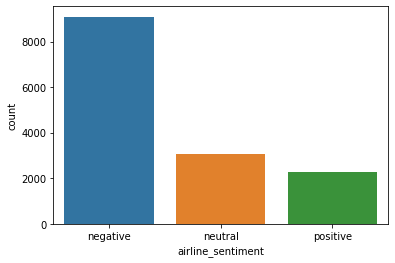

In [27]:
sns.countplot(x='airline_sentiment',data=df_no_dup)
# we could see that close to 63% of sentiment is negative.

#  3.5 - Text preprocessing

check some random text

In [ ]:
print(df_no_dup['text'].values[0])
print("="*100)
print(df_no_dup['text'].values[15])
print("="*100)
print(df_no_dup['text'].values[100])
print("="*100)
print(df_no_dup['text'].values[999])
print("="*100)
print(df_no_dup['text'].values[11000])
print("="*100)
print(df_no_dup['text'].values[12000])

#  Observation -

we could see that there are a lot of punctuations, web site names, emoticons etc. we need to remove all of these before applying any of the text to vector featurization techniques.

==== 3.5.1 - convert text into lower case 

In [35]:
allTexts = df_no_dup['text'].values.tolist()

In [37]:
def convertToLowerCase(col):
    text = col[0]
    text = text.lower()
    return text

In [38]:
df_no_dup['text'] = df_no_dup[['text']].apply(convertToLowerCase,axis=1)

==== 3.5.2 - Remove any URLs exist in the text

In [42]:
def removeUrls(col):
    text = col[0]
    newText = re.sub(r"http\S+", '', text)
    return newText

In [43]:
df_no_dup['text'] = df_no_dup[['text']].apply(removeUrls,axis=1)

In [44]:
# check if unwanted URLs are removed.
print(df_no_dup['text'].values[100])

@americanair ... do i have to even say anything?  over 6 hours on hold... no one has ever sucked as much as you. 


==== 3.5.3 - Remove any HTML tags if any

In [47]:
def removeHtmlTags(col):
    text = col[0]
    soup = BeautifulSoup(text, 'lxml')
    newText = soup.get_text()
    return newText

In [48]:
df_no_dup['text'] = df_no_dup[['text']].apply(removeHtmlTags,axis=1)

==== 3.5.4 - Expand english language contractions in data.

In [49]:
# Create a generic function which will return expanded phrases.
def decontracted(col):
    phrase = col[0]
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
df_no_dup['text'] = df_no_dup[['text']].apply(decontracted,axis=1)

==== 3.5.5 - Remove alphanumeric text.

In [51]:
def removeAlphaNumericText(col):
    text = col[0]
    text = re.sub("\S*\d\S*", "", text).strip()
    return text

In [52]:
df_no_dup['text'] = df_no_dup[['text']].apply(removeAlphaNumericText,axis=1)

==== 3.5.6 - Remove punctuations and special characters

In [53]:
def removeSpecialChar(col):
    text = col[0]
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

In [54]:
df_no_dup['text'] = df_no_dup[['text']].apply(removeSpecialChar,axis=1)

==== 3.5.7 - Remove stopwords.

In [55]:
import nltk
from nltk.corpus import stopwords

In [56]:
stopWords = set(stopwords.words('english'))

In [57]:
print(stopWords)

{"won't", 'by', "doesn't", 'any', 'mustn', 'not', "you're", "don't", 'll', 'then', 'were', 'them', 'haven', 'itself', "hasn't", 'and', 'until', 'of', 'below', 'shouldn', 'm', 'they', 'wouldn', 'don', 'from', 'up', 'only', 'further', 'which', 'aren', 'ours', 'or', 'isn', 'into', 'been', "you've", "shan't", 'am', 'at', 'i', 'was', "shouldn't", 'off', 'needn', "wouldn't", 'once', 'doing', 'these', 'to', "you'd", 'no', 'an', 'ain', 'mightn', 'ma', 'some', "weren't", 've', 'will', 'won', "didn't", 'have', 'few', 'most', 'are', 'our', "needn't", 'shan', "couldn't", 'your', 'more', "hadn't", 'about', 'ourselves', 'against', 'own', 'wasn', 'what', 'out', 'for', 'if', 'with', 'o', 'down', 'herself', 'above', 'but', 'under', "you'll", 'nor', 'there', 'here', 'too', 'now', 'is', 't', 'yourselves', 'be', "aren't", 's', 'before', 'himself', 're', 'as', 'we', 'its', 'how', 'being', 'same', "should've", 'hasn', 'so', 'than', 'myself', 'did', 'me', 'didn', 'he', 'where', 'doesn', 'you', 'him', 'her', 

In [58]:
# we have words like 'not' 'nor' 'no' in stopwords.
# lets remove these words.
stopWords.remove("not")
stopWords.remove("no")
stopWords.remove("nor")

In [59]:
stopWords.add('br')

In [60]:
# creating a generic function to remove stopwords.
def removeStopwords(col):
    sentence = col[0]
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopWords)
    return sentence

In [61]:
df_no_dup['text'] = df_no_dup[['text']].apply(removeStopwords,axis=1)

In [62]:
df_no_dup.head(5)

,index,airline_sentiment,airline,text
0,0,negative,American,nothelpful mt americanair call volume extremel...
1,1,negative,American,americanair sat runway hrs takeoff hrs late fl...
2,2,negative,American,americanair would great get help trying since ...
3,3,negative,American,americanair would nice could actually talk res...
4,4,negative,American,americanair usairways add insult injury guys m...


# Store intermediate processed data into Sqlite file.

In [63]:
conn = sqlite3.connect('processedData.sqlite')
c = conn.cursor()
conn.text_factory = str
df_no_dup.to_sql('processedData', conn, schema=None, if_exists='replace')

In [64]:
df_no_dup.head(5)

,index,airline_sentiment,airline,text
0,0,negative,American,nothelpful mt americanair call volume extremel...
1,1,negative,American,americanair sat runway hrs takeoff hrs late fl...
2,2,negative,American,americanair would great get help trying since ...
3,3,negative,American,americanair would nice could actually talk res...
4,4,negative,American,americanair usairways add insult injury guys m...


#  Label encoding of airline_sentiment column.

In [65]:
from sklearn.preprocessing import LabelEncoder

In [66]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

In [67]:
# Assigning numerical values and storing in another column
df_no_dup['airline_sentiment_encoded'] = labelencoder.fit_transform(df_no_dup['airline_sentiment'])

In [69]:
df_no_dup['airline_sentiment_encoded'].value_counts()

0    9087
1    3067
2    2298
Name: airline_sentiment_encoded, dtype: int64

In [70]:
df_no_dup.head(5)

,index,airline_sentiment,airline,text,airline_sentiment_encoded
0,0,negative,American,nothelpful mt americanair call volume extremel...,0
1,1,negative,American,americanair sat runway hrs takeoff hrs late fl...,0
2,2,negative,American,americanair would great get help trying since ...,0
3,3,negative,American,americanair would nice could actually talk res...,0
4,4,negative,American,americanair usairways add insult injury guys m...,0


# Split data into train and test

In [80]:
Y = df_no_dup['airline_sentiment_encoded'].values
X = df_no_dup['text'].values

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
# Simple cross validation.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting

In [83]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

(9682,) (9682,)
(4770,) (4770,)


# Apply BOW to convert text into numerical vectors.

# we could also use TFIDF, Word2Vec and compare results.

In [84]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [85]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#  Checking vector dimenions

In [86]:
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

# we get around 9k dimensions vectors.

After vectorizations
(9682, 9392) (9682,)
(4770, 9392) (4770,)


# Applying Naive Bayes ==

# As Naive Bayes is considered as a benchmark ML algorithm for text classification, we will use it. 

# we could also use different classifiers and compare model performance to come up with final model.

In [87]:
from sklearn.naive_bayes import MultinomialNB

In [95]:
# With default hyperparameter 1.0
nb = MultinomialNB()

In [90]:
nb.fit(X_train_bow, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
y_pred = nb.predict(X_test_bow)

#  Calculate f1 score

In [92]:
from sklearn.metrics import f1_score, confusion_matrix

In [94]:
print(f1_score(y_pred, y_test, average='micro'))

0.7622641509433963


#  Hyperparameter tuning

In [97]:
alpha_values = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1.0,1.1,1.2,1.3]
max_f1_score = float('-inf')
best_alpha = None
for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(X_train_bow, y_train)
    y_pred = clf.predict(X_test_bow)
    current_f1_score = f1_score(y_pred, y_test, average='micro')
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
        best_alpha = alpha

In [99]:
print('max f1 score is == ', max_f1_score)
print('best alpha is == ', best_alpha)

max f1 score is ==  0.7714884696016772
best alpha is ==  0.1
